# Relationship between data quality and model performance

## Imports and configuration

In [1]:
# basic configuration, put these lines at the top of each notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [169]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

In [78]:
plt.rcParams["figure.figsize"] = (16, 9)
pd.options.display.max_columns = None
pd.set_option('mode.chained_assignment', None)
pd.set_option("display.precision", 2)
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Load data

In [5]:
DATA_PATH = "../data/raw/"

In [6]:
identity = pd.read_csv(f'{DATA_PATH}train_identity.csv')
transaction = pd.read_csv(f'{DATA_PATH}train_transaction.csv')

In [7]:
raw = pd.merge(transaction, identity, on='TransactionID', how='left')
raw.shape

(590540, 434)

In [8]:
raw = raw.drop(columns=['TransactionID'])
raw.to_csv(f'{DATA_PATH}raw_merged.csv', index=False)

## Preprocess data

### Recode categorical features

In [9]:
cat_feats = ['isFraud', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
             'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
             'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
             'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
             'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
for feat in cat_feats:
    raw[feat] = raw[feat].astype('category')

### Remove all columns with at least 10% missing data

In [12]:
def missing_val_perc(df, levels, axis=0, target=None):
    data = df
    if target is not None:
        data = data.loc[data.isFraud == target]
    missing_vals = data.isnull().sum(axis=axis).sort_values(ascending=False) / data.shape[axis]
    for l in levels:
        perc = len(missing_vals.loc[missing_vals > l]) / len(missing_vals)
        print('Percentage with more than {:.0f}% missing values: {:.1f}%'.format(l * 100, perc * 100))

def remove_missing_vals(df, cutoff, axis=0):
    missing = df.isnull().sum(axis=axis).sort_values(ascending=False) / df.shape[axis]
    drop = missing.loc[missing > cutoff].index.to_list()
    result = df.drop(labels=drop, axis=(1 if axis == 0 else 0))
    return result

In [26]:
data = remove_missing_vals(raw, 0.1)
print(data.shape)

(590540, 111)


### Remove all rows with missing data

In [27]:
levels = [0.1, 0.2, 0.5]
missing_val_perc(data, levels, axis=1)

Percentage with more than 10% missing values: 0.2%
Percentage with more than 20% missing values: 0.1%
Percentage with more than 50% missing values: 0.0%


In [28]:
data = remove_missing_vals(data, 0.0, axis=1)
print(data.shape)

(578081, 111)


In [29]:
data.isnull().sum().sum()

0

## Engineer features

### Deal with categorical variables

In [30]:
def cont_cat_split(df, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var: continue
        if df[label].dtype == int or df[label].dtype == float: cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [31]:
cont_vars, cat_vars = cont_cat_split(data, dep_var='isFraud')
print(len(cont_vars))
print(len(cat_vars))

103
7


In [32]:
def concat_long_tail(df, cat_vars, n=10):
    for cat in cat_vars:
        col = df[cat]
        top_n_cats = list(col.value_counts().index[:n])
        mask = [False if row in top_n_cats else True for row in col]
        fill_val = ("other" if str(col.cat.categories.dtype) == "object" else 0)
        col.cat.add_categories(fill_val, inplace=True)
        temp = col.mask(mask, other=fill_val)
        temp.cat.remove_unused_categories(inplace=True)
        df[cat] = temp
    return df

In [33]:
data = concat_long_tail(data, cat_vars)

In [34]:
def one_hot_encode(data, cat_vars):
    one_hot_data = pd.get_dummies(data[cat_vars], prefix=cat_vars)
    data = data.drop(columns=cat_vars)
    return pd.concat([data, one_hot_data], axis=1)

In [35]:
data = one_hot_encode(data, cat_vars)
print(data.shape)
data.head()

(578081, 161)


,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card1_2803,card1_6019,card1_7585,card1_7919,card1_9500,card1_12544,card1_12695,card1_15066,card1_15885,card1_17188,card1_0,card2_111.0,card2_170.0,card2_194.0,card2_321.0,card2_360.0,card2_490.0,card2_514.0,card2_545.0,card2_555.0,card2_583.0,card2_0.0,card3_102.0,card3_106.0,card3_117.0,card3_119.0,card3_143.0,card3_144.0,card3_146.0,card3_147.0,card3_150.0,card3_185.0,card3_0.0,card4_american express,card4_discover,card4_mastercard,card4_visa,card5_102.0,card5_117.0,card5_126.0,card5_137.0,card5_138.0,card5_166.0,card5_195.0,card5_219.0,card5_224.0,card5_226.0,card5_0.0,card6_charge card,card6_credit,card6_debit,card6_debit or credit
1,0,86401,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,86469,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,86499,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,86506,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,86510,49.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### Decompose datetime variable

In [36]:
def make_day_feature(col, offset=0):
    days = col / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(col):
    hours = col / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

def decompose_datetime(data, dt_var, day_offset=0.58):
    data['day'] = make_day_feature(data[dt_var], offset=day_offset).astype('int64').astype('category')
    data['hour'] = make_hour_feature(data[dt_var]).astype('int64').astype('category')
    data = data.drop(columns=[dt_var])
    return data

In [37]:
data = decompose_datetime(data, 'TransactionDT')
print(data.shape)

(578081, 162)


### Rescale numerical variables

In [38]:
cont_vars, cat_vars = cont_cat_split(data, dep_var='isFraud')
print(len(cont_vars))
print(len(cat_vars))

102
59


In [39]:
def rescale_cont_vars(data, cont_vars, log_transform=True):
    if log_transform:
        log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False)
        data[cont_vars] = log_transformer.fit_transform(data[cont_vars])
    scaler = MinMaxScaler()
    data[cont_vars] = scaler.fit_transform(data[cont_vars])
    return data

In [42]:
data = rescale_cont_vars(data, cont_vars)
print(data.shape)
data.head()

(578081, 162)


,isFraud,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card1_2803,card1_6019,card1_7585,card1_7919,card1_9500,card1_12544,card1_12695,card1_15066,card1_15885,card1_17188,card1_0,card2_111.0,card2_170.0,card2_194.0,card2_321.0,card2_360.0,card2_490.0,card2_514.0,card2_545.0,card2_555.0,card2_583.0,card2_0.0,card3_102.0,card3_106.0,card3_117.0,card3_119.0,card3_143.0,card3_144.0,card3_146.0,card3_147.0,card3_150.0,card3_185.0,card3_0.0,card4_american express,card4_discover,card4_mastercard,card4_visa,card5_102.0,card5_117.0,card5_126.0,card5_137.0,card5_138.0,card5_166.0,card5_195.0,card5_219.0,card5_224.0,card5_226.0,card5_0.0,card6_charge card,card6_credit,card6_debit,card6_debit or credit,day,hour
1,0,0.31,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.00,0.00,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0.38,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.13,0.00,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0,0.37,0.13,0.21,0.0,0.0,0.0,0.21,0.0,0.00,0.13,0.00,0.09,0.0,0.41,0.1,0.73,0.1,0.54,0.49,0.0,0.53,0.48,0.1,0.51,0.47,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.33,0.62,0.57,0.0,0.54,0.45,0.34,0.61,0.58,0.0,0.0,0.0,0.1,0.49,0.0,0.0,0.00,0.0,0.53,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.1,0.51,0.47,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.34,0.63,0.59,0.0,0.54,0.0,0.45,0.0,0.0,0.0,0.34,0.61,0.58,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0.37,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.09,0.00,0.09,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.23,0.24,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0.36,0.08,0.08,0.0,0.0,0.0,0.09,0.0,0.00,0.13,0.00,0.09,0.0,0.09,0.1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.33,0.33,0.33,0.3,0.3,0.3,0.36,0.36,0.36,0.5,0.5,0.5,0.5,0.5,0.5,0.26,0.26,0.26,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,

### Create validation set

In [43]:
data_train, data_valid = train_test_split(data, test_size=10000, random_state=47)

In [44]:
print(data_train.isFraud.value_counts())
print(data_train.isFraud.value_counts(normalize=True))

0    548444
1     19637
Name: isFraud, dtype: int64
0    0.97
1    0.03
Name: isFraud, dtype: float64


In [45]:
print(data_valid.isFraud.value_counts())
print(data_valid.isFraud.value_counts(normalize=True))

0    9621
1     379
Name: isFraud, dtype: int64
0    0.96
1    0.04
Name: isFraud, dtype: float64


### Balance training data set

In [46]:
fraud = data_train[data_train.isFraud == 1]
valid = data_train[data_train.isFraud == 0]

In [47]:
TARGET_SIZE = 100000
valid = resample(valid, replace=False, n_samples=(TARGET_SIZE - len(fraud)), random_state=47)
data_train = pd.concat([fraud, valid])
print(data_train.shape)
print(data_train.isFraud.value_counts())
print(data_train.isFraud.value_counts(normalize=True))

(100000, 162)
0    80363
1    19637
Name: isFraud, dtype: int64
0    0.8
1    0.2
Name: isFraud, dtype: float64


### Separate features and target variable 

In [48]:
def split_data(df, dep_var):
    return df.drop(columns=[dep_var]), df[dep_var]

In [49]:
X_train, y_train = split_data(data_train, 'isFraud')
X_valid, y_valid = split_data(data_valid, 'isFraud')
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(100000, 161)
(10000, 161)
(100000,)
(10000,)


## Prepare experiment

In [93]:
def missing_perc(data):
    print(data.isnull().sum().sum() / (data.shape[0] * data.shape[1]))
    return

In [94]:
def mark_as_missing(data, na_perc):
    k = int(np.floor(na_perc * len(data)))
    for cat in data.columns:
        idx = random.sample(list(range(len(data))), k)
        data[cat].iloc[idx] = None
    return data

In [96]:
def impute_missing(df, dep_var=None):
    cont_vars, cat_vars = cont_cat_split(df, dep_var=dep_var)
    cont_imputer = SimpleImputer(missing_values=np.NaN, strategy="median")
    df[cont_vars] = cont_imputer.fit_transform(df[cont_vars])
    cat_imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
    df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])
    return df

In [144]:
def obscure_feats(data, perc, dep_var=None):
    cont_vars, cat_vars = cont_cat_split(df, dep_var=dep_var)
    k = int(np.floor(perc * len(data)))
    for cat in cont_vars:
        idx = random.sample(list(range(len(data))), k)
        data.iloc[idx, cat] = np.random.random_sample(len(idx))
    for cat in cat_vars:
        idx = random.sample(list(range(len(data))), k)
        data[cat].iloc[idx] = np.random.randint(0, high=2, size=len(idx))
    return data

In [160]:
def obscure_labels(data, perc):
    k = int(np.floor(perc * len(data)))
    idx = random.sample(list(range(len(data))), k)
    data.iloc[idx] = data.iloc[idx].apply(lambda x: 1 - x)
    return data

In [103]:
def eval_model(model, X, y):
    pred = model.predict_proba(X)
    if pred.shape[1] == 1:
        pred = np.hstack((pred, np.expand_dims(np.zeros(len(pred)), -1)))
    return roc_auc_score(y, pred[:, 1])

In [170]:
def data_quality_experiment(model, X_train, y_train, X_valid, y_valid, quality_levels, missing_vals=True, wrong_feats=True, wrong_labels=True, rounds=10):
    results = []
    for qual in quality_levels:
        scores = []
        for _ in range(rounds):
            X = X_train.copy()
            y = y_train.copy()
            if missing_vals:
                X = impute_missing(mark_as_missing(X, qual))
            if wrong_feats:
                X = obscure_feats(X, qual)
            if wrong_labels:
                y = obscure_labels(y, qual)
            model.fit(X, y)
            score = eval_model(model, X_valid, y_valid)
            scores.append(score)
        results.append({'classifier': type(model).__name__, 'missing_vals': missing_vals, 'wrong_feats': wrong_feats, 'wrong_labels': wrong_labels, 'quality_level': (1-qual), 'auc_mean': np.mean(scores), 'auc_std': np.std(scores)})
        print(f"completed {rounds} rounds with {(1-qual)*100}% quality level")
    return pd.DataFrame(data=results)

## Conduct experiment

### Get run time estimate

In [171]:
rf = RandomForestClassifier()

In [172]:
%time rf.fit(X_train, y_train)

CPU times: user 29.7 s, sys: 344 ms, total: 30.1 s
Wall time: 30.2 s


RandomForestClassifier()

### Run experiment

In [173]:
QUAL_LEVELS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
rf = RandomForestClassifier()
rf_results = data_quality_experiment(rf, X_train, y_train, X_valid, y_valid, QUAL_LEVELS, rounds=10)
rf_results

completed 10 rounds with 100.0% quality level
completed 10 rounds with 90.0% quality level
completed 10 rounds with 80.0% quality level
completed 10 rounds with 70.0% quality level
completed 10 rounds with 60.0% quality level
completed 10 rounds with 50.0% quality level


,classifier,missing_vals,wrong_feats,wrong_labels,quality_level,auc_mean,auc_std
0,RandomForestClassifier,True,True,True,1.0,0.91,1.91e-03
1,RandomForestClassifier,True,True,True,0.9,0.89,5.99e-03
2,RandomForestClassifier,True,True,True,0.8,0.87,6.78e-03
3,RandomForestClassifier,True,True,True,0.7,0.83,6.13e-03
4,RandomForestClassifier,True,True,True,0.6,0.76,1.22e-02
5,RandomForestClassifier,True,True,True,0.5,0.50,2.16e-02


In [174]:
lr = LogisticRegression()
lr_results = data_quality_experiment(lr, X_train, y_train, X_valid, y_valid, QUAL_LEVELS, rounds=10)
lr_results

completed 10 rounds with 100.0% quality level
completed 10 rounds with 90.0% quality level
completed 10 rounds with 80.0% quality level
completed 10 rounds with 70.0% quality level
completed 10 rounds with 60.0% quality level
completed 10 rounds with 50.0% quality level


,classifier,missing_vals,wrong_feats,wrong_labels,quality_level,auc_mean,auc_std
0,LogisticRegression,True,True,True,1.0,0.86,1.11e-16
1,LogisticRegression,True,True,True,0.9,0.85,2.96e-03
2,LogisticRegression,True,True,True,0.8,0.84,1.32e-03
3,LogisticRegression,True,True,True,0.7,0.83,2.66e-03
4,LogisticRegression,True,True,True,0.6,0.82,5.80e-03
5,LogisticRegression,True,True,True,0.5,0.48,5.97e-02


## Visualize results

In [175]:
rf_results.append([lr_results], ignore_index=True).to_csv("data_qual_results.csv", index=False)

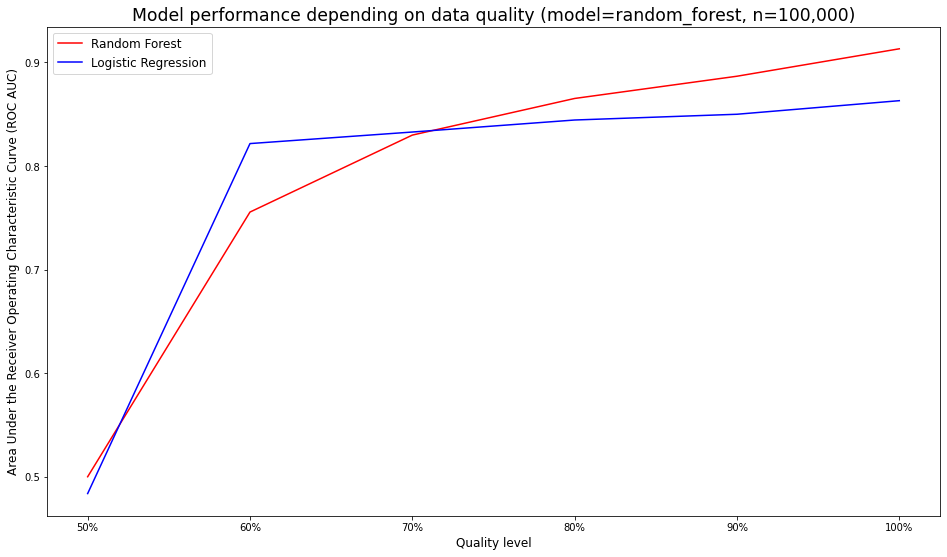

In [180]:
xticks = [1 - q for q in QUAL_LEVELS]
fig, ax = plt.subplots()
ax.plot(rf_results[['quality_level']], rf_results[['auc_mean']], 'r-', label='Random Forest')
ax.plot(lr_results[['quality_level']], lr_results[['auc_mean']], 'b-', label='Logistic Regression')
leg = ax.legend(fontsize='large')
plt.title('Model performance depending on data quality (model=random_forest, n=100,000)', fontsize='xx-large')
plt.ylabel('Area Under the Receiver Operating Characteristic Curve (ROC AUC)', fontsize='large')
plt.xlabel('Quality level', fontsize='large')
plt.xticks(xticks, labels=[f'{int(t*100)}%' for t in xticks])
plt.show()